# Pytorch-shap-预训练图像分类可解释性分析

对Pytorch模型库中的ImageNet预训练图像分类模型进行可解释性分析。可视化指定预测类别的shap值热力图。

## 导入工具包

In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import shap
import sys 
sys.path.append("..")
from train_come15k import copy_state_dict
import os
fater_path = os.path.abspath('..')
print(fater_path)
os.chdir(fater_path)

/home/mark/Documents/PythonProject/ShuffleNet-Retrain/ShuffleNetV2+


## easyimport sys 
sys.path.append("..") 

In [2]:
# 数据集文件夹路径
dataset_name = 'test_easy_classes'
# dataset_name = 'test_hard_classes'
model_path = './models/2023-12-14-17:59_max_epoch_100-afterSOD/'
model_name = 'retrain_COME15K_checkpoint-best-avg-0.544-Medium.pth.tar'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)


# 类别名称 和 ID索引号 的映射字典
class_names_dic = {0: 'covering', 1: 'device', 2: 'domestic_animal', 3: 'mater', 4: 'person', 5: 'plant',
                       6: 'structure', 7: 'vertebrate'}
# 获得类别名称
class_names = list(class_names_dic.values())
print(class_names)

device cuda:0
['covering', 'device', 'domestic_animal', 'mater', 'person', 'plant', 'structure', 'vertebrate']


## 载入预训练图像分类模型(ImageNet1K)

In [3]:
# from network import ShuffleNetV2_Plus
# ## 载入ImageNet1k预训练图像分类模型

# # init model choose ['Small','Medium','Large']
# model_size = 'Medium'
# architecture = [0, 0, 3, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 3, 2]
# model = ShuffleNetV2_Plus(architecture=architecture, n_class=class_names.__len__(), model_size=model_size)
# pre_train_model_weight_dic = {
#     'Small': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Small.pth.tar',
#     'Medium': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Medium.pth.tar',
#     'Large': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Large.pth.tar'
#     }
# # 载入预训练
# pre_train_weight = torch.load(pre_train_model_weight_dic[model_size])
# # 去掉分类层
# new_dict = copy_state_dict(pre_train_weight)
# keys = []
# for k, v in new_dict.items():
#     if k.startswith('classifier'):  # 将‘’开头的key过滤掉，这里是要去除的层的key
#         continue
#     keys.append(k)
# new_dict = {k: new_dict[k] for k in keys}
# state_dict = new_dict
# model.load_state_dict(state_dict, strict=False)

model size is  Medium
Shuffle3x3
Shuffle3x3
Xception
Shuffle5x5
Shuffle5x5
Shuffle5x5
Shuffle3x3
Shuffle3x3
Shuffle7x7
Shuffle3x3
Shuffle7x7
Shuffle5x5
Shuffle5x5
Shuffle3x3
Shuffle7x7
Shuffle3x3
Shuffle7x7
Shuffle5x5
Xception
Shuffle7x7


_IncompatibleKeys(missing_keys=['classifier.0.weight'], unexpected_keys=[])

## 载入预训练图像分类模型(COME15K-DATASET)

In [3]:
# 数据集文件夹路径
dataset_name = 'test_easy_classes'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# init model
model_and_weight_path = model_path + model_name
model = torch.load(model_and_weight_path)
model = model.eval().to(device)
model

ShuffleNetV2_Plus(
  (first_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
    (2): HS()
  )
  (features): Sequential(
    (0): Shufflenet(
      (branch_main): Sequential(
        (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (5): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
      )
     

## 载入一张测试图像，整理维度

In [4]:
img_path = 'data/SOD-SemanticDataset-OriginalSize/test/COME15K-Easy/COME_Easy_1.jpg'

In [5]:
img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [6]:
X.shape

torch.Size([1, 360, 640, 3])

## 预处理

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 构建模型预测函数

In [8]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [9]:
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [10]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [11]:
out.shape

torch.Size([1, 8])

In [12]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(classes)
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

[2]
Classes: [2]: ['domestic_animal']


## 设置shap可解释性分析算法

In [13]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [14]:
input_img.shape

torch.Size([1, 224, 398, 3])

In [15]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [16]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:11, 11.80s/it]                                     


In [17]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [18]:
# 原图
shap_values.data.shape

(224, 398, 3)

In [19]:
# shap值热力图
shap_values.values[0].shape

(224, 398, 3)

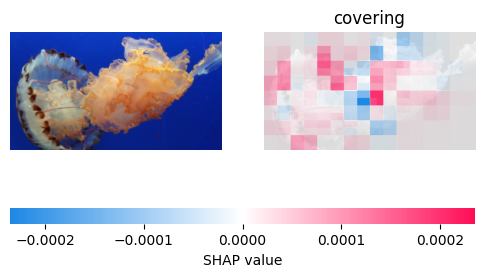

In [20]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [21]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0, 1, 2, 3])

  0%|          | 0/4998 [00:00<?, ?it/s]

In [22]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [23]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(4, 224, 398, 3)

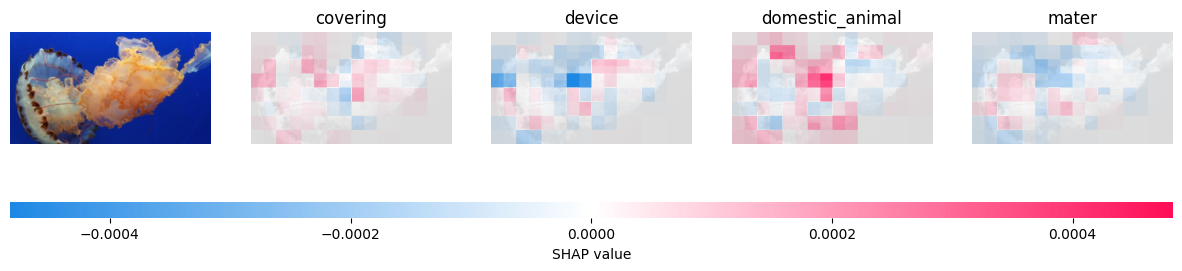

In [24]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前k个预测类别

In [25]:
topk = 8

In [26]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/4998 [00:00<?, ?it/s]

In [27]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(1, 224, 398, 3, 8)

In [28]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [29]:
# 各个类别的shap值热力图
len(shap_values.values)

8

In [30]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

(224, 398, 3)

In [31]:
# 第一个类别，shap值热力图
shap_values.values[1].shape

(224, 398, 3)

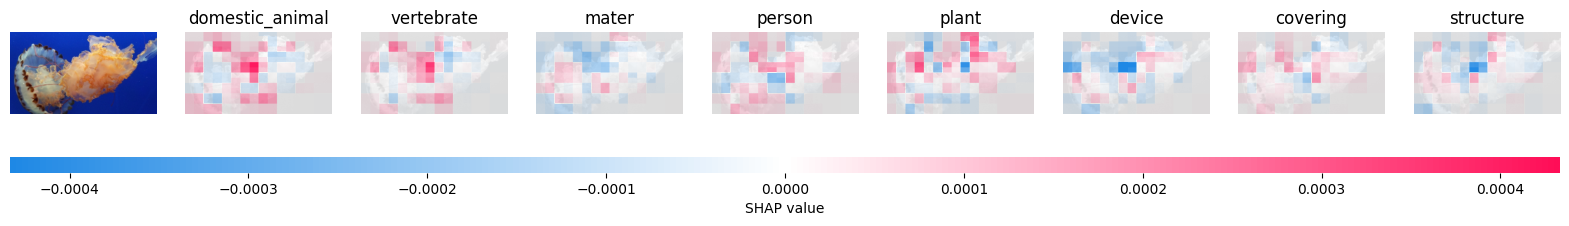

In [32]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )

## hard

In [54]:
# 数据集文件夹路径
dataset_name = 'test_hard_classes'
model_path = './models/2023-12-14-17:59_max_epoch_100-afterSOD/'
model_name = 'retrain_COME15K_checkpoint-best-avg-0.544-Medium.pth.tar'
dataset_dir = '../data_class_txt/'+ dataset_name + '.txt'
# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)


# 类别名称 和 ID索引号 的映射字典
class_names_dic = {0: 'covering', 1: 'device', 2: 'domestic_animal', 3: 'mater', 4: 'person', 5: 'plant',
                       6: 'structure', 7: 'vertebrate'}
# 获得类别名称
class_names = list(class_names_dic.values())
print(class_names)

device cuda:0
['covering', 'device', 'domestic_animal', 'mater', 'person', 'plant', 'structure', 'vertebrate']


## 载入预训练图像分类模型(ImageNet1K)

In [55]:
# from network import ShuffleNetV2_Plus
# ## 载入ImageNet1k预训练图像分类模型

# # init model choose ['Small','Medium','Large']
# model_size = 'Medium'
# architecture = [0, 0, 3, 1, 1, 1, 0, 0, 2, 0, 2, 1, 1, 0, 2, 0, 2, 1, 3, 2]
# model = ShuffleNetV2_Plus(architecture=architecture, n_class=class_names.__len__(), model_size=model_size)
# pre_train_model_weight_dic = {
#     'Small': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Small.pth.tar',
#     'Medium': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Medium.pth.tar',
#     'Large': 'shuffle_net_v2_plus_image1K_pretrianed_weight/ShuffleNetV2+.ImageNet1k_pre_trained_Large.pth.tar'
#     }
# # 载入预训练
# pre_train_weight = torch.load(pre_train_model_weight_dic[model_size])
# # 去掉分类层
# new_dict = copy_state_dict(pre_train_weight)
# keys = []
# for k, v in new_dict.items():
#     if k.startswith('classifier'):  # 将‘’开头的key过滤掉，这里是要去除的层的key
#         continue
#     keys.append(k)
# new_dict = {k: new_dict[k] for k in keys}
# state_dict = new_dict
# model.load_state_dict(state_dict, strict=False)

## 载入预训练图像分类模型(COME15K-DATASET)

In [56]:
# init model
model_and_weight_path = model_path + model_name
model = torch.load(model_and_weight_path)
model = model.eval().to(device)
model

ShuffleNetV2_Plus(
  (first_conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
    (2): HS()
  )
  (features): Sequential(
    (0): Shufflenet(
      (branch_main): Sequential(
        (0): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (5): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.0012468827930174563, affine=True, track_running_stats=True)
        (7): ReLU(inplace=True)
      )
     

## 载入一张测试图像，整理维度

In [57]:
img_path = 'data/SOD-SemanticDataset-OriginalSize/test/COME15K-Hard/COME_Hard_1.jpg'

In [58]:
img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [59]:
X.shape

torch.Size([1, 360, 640, 3])

## 预处理

In [60]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

## 构建模型预测函数

In [61]:
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [62]:
def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

## 测试整个工作流正常

In [63]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [64]:
out.shape

torch.Size([1, 8])

In [65]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(classes)
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

[4]
Classes: [4]: ['person']


## 设置shap可解释性分析算法

In [66]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [67]:
input_img.shape

torch.Size([1, 224, 398, 3])

In [68]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

## 指定单个预测类别

In [69]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0])

  0%|          | 0/4998 [00:00<?, ?it/s]

In [70]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [71]:
# 原图
shap_values.data.shape

(224, 398, 3)

In [72]:
# shap值热力图
shap_values.values[0].shape

(224, 398, 3)

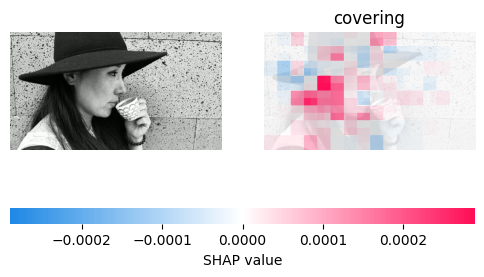

In [73]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 指定多个预测类别

In [74]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[0, 1, 2, 3])

  0%|          | 0/4998 [00:00<?, ?it/s]

In [75]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

In [76]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(4, 224, 398, 3)

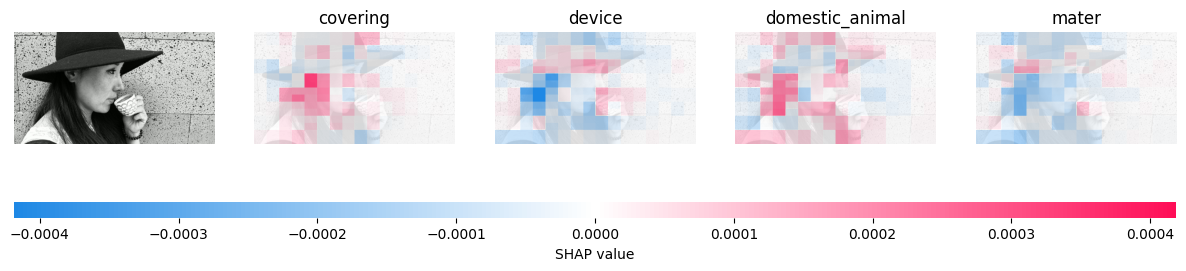

In [77]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

## 前k个预测类别

In [78]:
topk = 8

In [79]:
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

  0%|          | 0/4998 [00:00<?, ?it/s]

In [80]:
# shap值热力图：每个像素，对于每个类别的shap值
shap_values.shape

(1, 224, 398, 3, 8)

In [81]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

In [82]:
# 各个类别的shap值热力图
len(shap_values.values)

8

In [83]:
# 第一个类别，shap值热力图
shap_values.values[0].shape

(224, 398, 3)

In [84]:
# 第一个类别，shap值热力图
shap_values.values[1].shape

(224, 398, 3)

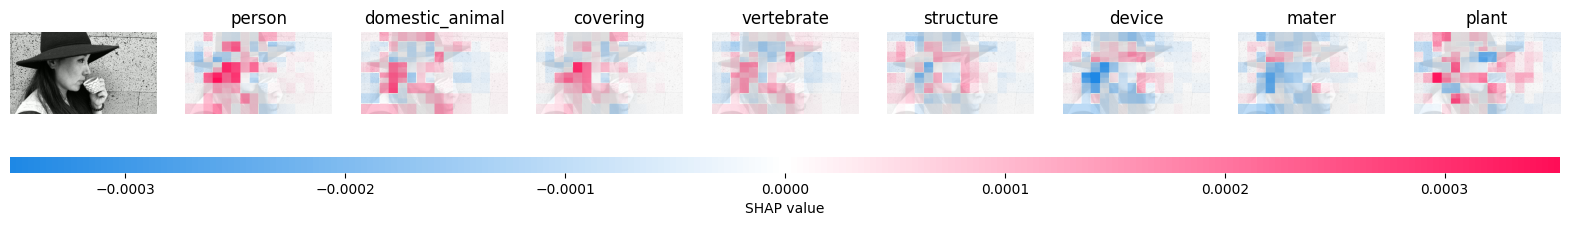

In [85]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )